In [1]:

import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

2024-01-17 17:49:11.632802: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-17 17:49:11.653041: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 17:49:11.653059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 17:49:11.653594: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 17:49:11.657162: I tensorflow/core/platform/cpu_feature_guar

In [2]:
x = pd.read_csv("Cary_Weather_Data.csv")
x['DATE'] = pd.to_datetime(x[['YEAR', 'MONTH', 'DAY']])
x = x.drop(columns=['YEAR','MONTH','DAY'])
#x = x.drop(columns=['Humidity','Precipitation','Wind Speed'])
x = x[['DATE', 'Temperature', 'Humidity', 'Precipitation', 'Wind Speed']]
x.head()
x.set_index('DATE', inplace=True)
x.head()


,Temperature,Humidity,Precipitation,Wind Speed
DATE,,,,
1981-07-01,15.12,10.68,6.65,3.59
1981-07-02,7.53,13.12,10.68,1.64
1981-07-03,7.32,13.79,37.42,2.43
1981-07-04,10.43,14.40,8.41,2.29
1981-07-05,13.13,15.20,4.13,1.58


In [3]:
scaler = StandardScaler()
x_scale = scaler.fit_transform(x)
x_scale = pd.DataFrame(x_scale, columns=x.columns, index=x.index)
x_scale = x_scale.drop(columns=['Humidity', 'Precipitation', 'Wind Speed'])
x_scale.head()

,Temperature
DATE,
1981-07-01,0.926990
1981-07-02,-1.305674
1981-07-03,-1.367448
1981-07-04,-0.452614
1981-07-05,0.341614


In [4]:
def create_dataset(X, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(X.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [5]:
time_steps = 1

X, y = create_dataset(x_scale, time_steps)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=False)
X_train.shape
X_val.shape

(3106, 1, 1)

In [6]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(time_steps, 1)))
model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, 'linear'))

cp = tf.keras.callbacks.ModelCheckpoint('model', save_best_only=True)
#model.compile(loss='mse', optimizer='adam', metrics=['rmse'])
model.summary()

2024-01-17 17:49:13.449207: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 17:49:13.475376: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 17:49:13.485503: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

InternalError: cudaSetDevice() on GPU:0 failed. Status: out of memory

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [ ]:
cp = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
history = model.fit(X_train, y_train, epochs=10, callbacks=cp)

Epoch 1/10


2024-01-17 09:20:40.444012: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-17 09:20:40.962638: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbb7507c090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-17 09:20:40.962665: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-01-17 09:20:40.966882: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705501241.004283    6835 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


389/389 [==============================] - 9s 15ms/step - loss: 0.3841 - mae: 0.7486
Epoch 2/10
389/389 [==============================] - 6s 15ms/step - loss: 0.3657 - mae: 0.7250
Epoch 3/10
389/389 [==============================] - 6s 16ms/step - loss: 0.3647 - mae: 0.7236
Epoch 4/10
389/389 [==============================] - 5s 12ms/step - loss: 0.3650 - mae: 0.7238
Epoch 5/10
389/389 [==============================] - 5s 14ms/step - loss: 0.3644 - mae: 0.7236
Epoch 6/10
389/389 [==============================] - 6s 16ms/step - loss: 0.3644 - mae: 0.7233
Epoch 7/10
389/389 [==============================] - 6s 15ms/step - loss: 0.3647 - mae: 0.7234
Epoch 8/10
389/389 [==============================] - 6s 16ms/step - loss: 0.3651 - mae: 0.7238
Epoch 9/10
389/389 [==============================] - 7s 17ms/step - loss: 0.3640 - mae: 0.7226
Epoch 10/10
389/389 [==============================] - 5s 14ms/step - loss: 0.3646 - mae: 0.7230


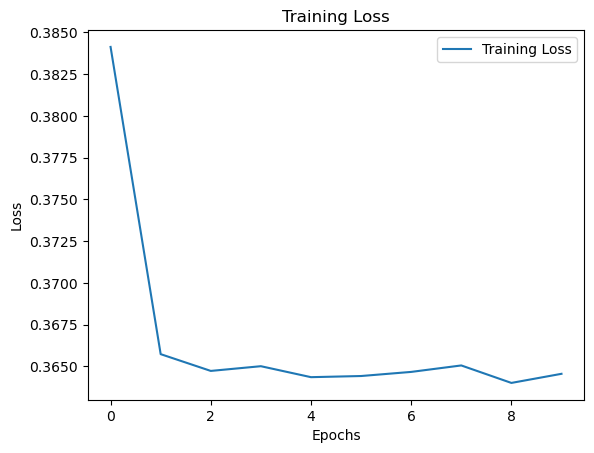

In [ ]:
matplotlib.interactive(True)
%matplotlib inline
plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
prediction = model.predict(X_val)
prediction_reshape = prediction[:, 0]
x_val_reshz = X_val[:, 0, 0]

98/98 [==============================] - 1s 2ms/step


In [ ]:
time_val = x.index[-len(X_val):]

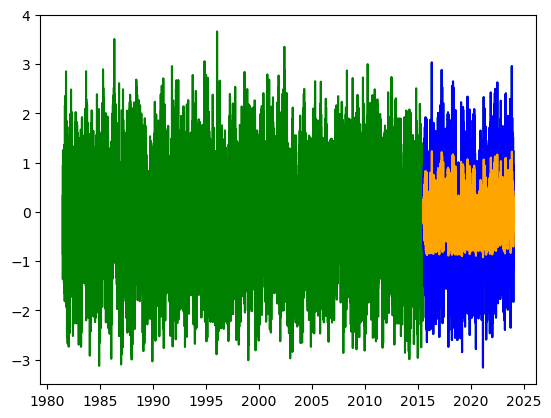

In [ ]:
plt.plot(x_scale['Temperature'], color='green')
plt.plot(time_val, x_val_reshz, label='Actual', color='blue')
plt.plot(time_val, prediction_reshape, label='Prediction', color='orange')
plt.show()